In [1]:
import numpy as np
import pandas as pd
import warnings
import os
from datasets import load_dataset
from lambeq import BobcatParser
warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"

/home/jd5018/.local/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/ext3/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/ext3/miniconda3/lib/python3.11/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


## 1) Read in the data and create diagrams

### Skip below cell

In [2]:
### Still working on getting this cell to work. Bobcatarser cannot parse some sentences
# def read_sst2(data_type="train"):
#     dataset = load_dataset("gpt3mix/sst2")

#     data = dataset[data_type]

#     usr_data = []
#     usr_labels = []

#     for example in data:
#         usr_data.append(example["text"])
#         usr_labels.append(example["label"])

#     print("First sentence:", usr_data[0])
#     print("First label:", usr_labels[0])

#     return usr_data,usr_labels

# train_data,train_labels = read_sst2("train")
# dev_data,dev_labels = read_sst2("validation")
# test_data,test_labels = read_sst2("test")

In [2]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('datasets/mc_train_data.txt')
dev_labels, dev_data = read_data('datasets/mc_dev_data.txt')
test_labels, test_data = read_data('datasets/mc_test_data.txt')

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


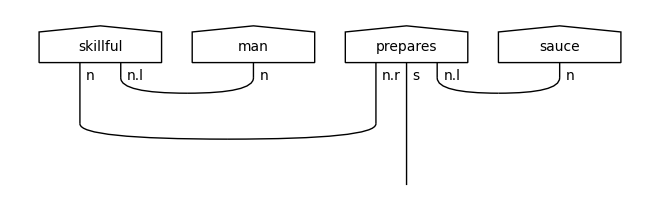

In [3]:
parser = BobcatParser(verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data)
raw_dev_diagrams = parser.sentences2diagrams(dev_data)
raw_test_diagrams = parser.sentences2diagrams(test_data)

raw_train_diagrams[0].draw()

In [4]:
"""from lambeq import RemoveCupsRewriter

remove_cups = RemoveCupsRewriter()

print("Before removing cups")
raw_train_diagrams[0].draw()

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

print("After removing cups")
train_diagrams[0].draw()
"""
## NOT REMOVING CUPS

train_diagrams = raw_train_diagrams
dev_diagrams = raw_dev_diagrams
test_diagrams = raw_test_diagrams



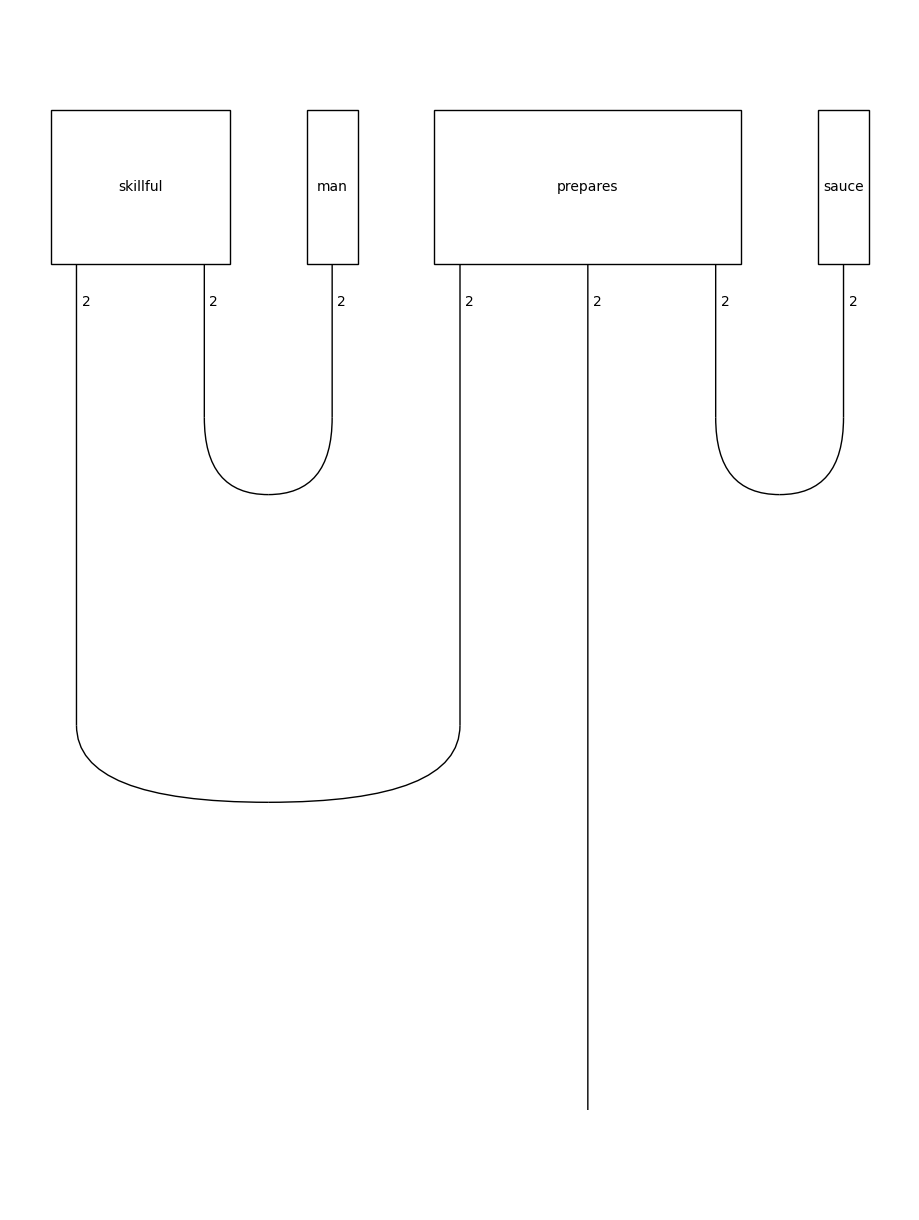

In [18]:
from lambeq import AtomicType, IQPAnsatz, BaseAnsatz, CircuitAnsatz, MPSAnsatz, Sim14Ansatz, Sim15Ansatz, SpiderAnsatz, StronglyEntanglingAnsatz, Symbol, TensorAnsatz

#ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
 #                  n_layers=1, n_single_qubit_params=3)

from lambeq.backend.tensor import Dim

N = AtomicType.NOUN
S = AtomicType.SENTENCE

# Create an ansatz 
# ansatz = SpiderAnsatz({N: Dim(2), S: Dim(2)})
# ansatz = MPSAnsatz({N: Dim(2), S: Dim(2)}, bond_dim=3)
ansatz = TensorAnsatz({N: Dim(2), S: Dim(2)})

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(9, 12))

# Step 5: Choosing a backend
We are now going to choose a backend on which our quantum circuits is going to be run. In this workshop we are going to use a classical simulator (a classical computer which simulates the bahaviour of a real quantum computer) to run our circuits. 

In [19]:
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

all_circuits = train_circuits+dev_circuits+test_circuits

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}

# Step 6: Creating the quantum sentence classifier. 

The code below trains our quantum sentence classifier. Since the training can take a few minutes we could alternatively work with a pre-trained model which you can load from the `checkpoint.pickle` file.

In [20]:
from lambeq import BinaryCrossEntropyLoss

#model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

import torch
from lambeq import PytorchModel

model = PytorchModel.from_diagrams(all_circuits)

# loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss

sig = torch.sigmoid

def acc(y_hat, y):
    return torch.sum(torch.eq(torch.round(sig(y_hat)), y))/len(y)/2  # half due to double-counting

eval_metrics = {"acc": acc}

from lambeq import QuantumTrainer, SPSAOptimizer

EPOCHS = 120
BATCH_SIZE = 30

from lambeq import PytorchTrainer


trainer = PytorchTrainer(
        model=model,
        loss_function=torch.nn.BCEWithLogitsLoss(),
        optimizer=torch.optim.AdamW,
        learning_rate=3e-2,
        epochs=EPOCHS,
        evaluate_functions=eval_metrics,
        evaluate_on_train=True,
        verbose='text',
        seed=0)



from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(dev_circuits, dev_labels, shuffle=False)

In [32]:
trainer.fit(train_dataset, val_dataset, log_interval=1)

Epoch 1:    train/loss: 0.9354   valid/loss: 0.7488   train/acc: 0.5000   valid/acc: 0.5333
Epoch 2:    train/loss: 0.7746   valid/loss: 0.7265   train/acc: 0.5214   valid/acc: 0.5333
Epoch 3:    train/loss: 0.6924   valid/loss: 0.7167   train/acc: 0.5286   valid/acc: 0.5333
Epoch 4:    train/loss: 0.6995   valid/loss: 0.7123   train/acc: 0.5643   valid/acc: 0.5333
Epoch 5:    train/loss: 0.6569   valid/loss: 0.7101   train/acc: 0.5714   valid/acc: 0.5167
Epoch 6:    train/loss: 0.5923   valid/loss: 0.7088   train/acc: 0.5643   valid/acc: 0.5167
Epoch 7:    train/loss: 0.6940   valid/loss: 0.7072   train/acc: 0.5643   valid/acc: 0.5333
Epoch 8:    train/loss: 0.7047   valid/loss: 0.7058   train/acc: 0.5571   valid/acc: 0.5333
Epoch 9:    train/loss: 0.6114   valid/loss: 0.7034   train/acc: 0.5500   valid/acc: 0.5500
Epoch 10:   train/loss: 0.6298   valid/loss: 0.7003   train/acc: 0.5857   valid/acc: 0.5167
Epoch 11:   train/loss: 0.6738   valid/loss: 0.6959   train/acc: 0.5929   valid/

In [21]:
model = PytorchModel.from_checkpoint('models/classifier-Tensor.pickle')
# model.save("models/classifier-Spider.pickle")
# model.save("models/classifier-MPS.pickle")
# model.save("models/classifier-Tensor.pickle")

In [22]:
def measure_score(model):
        test_pred = model.get_diagram_output(test_circuits).tolist()
        total = 0
        for i in range(len(test_pred)):
            if test_pred[i][0]>=0.5:
                test_pred[i][0],test_pred[i][1]=1.0,0.0
            else:
                test_pred[i][0],test_pred[i][1]=0.0,1.0
            if test_pred[i][0]==test_labels[i][0] and test_pred[i][1]==test_labels[i][1]:
                total+=1
        return total/len(test_labels)

measure_score(model)

1.0

## Tensor-based Ansatz Experiment Results

### Spider-Ansatz
- 1.0
### MPS-Ansatz
- 1.0
### Tensor-Ansatz
- 1.0